In [187]:
import numpy as np
from matplotlib import pyplot as plt

import os
import glob
import cv2

In [188]:
PIXELSIZE = 32 #28, 32
PIXELTIMES = 1024 # 784, 1024

In [189]:
root_dir = "asl_alphabet_train"
image_data = {}

In [190]:
for class_folder in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_folder)
    if os.path.isdir(class_path):
        class_images = []
        for image_file in glob.glob(os.path.join(class_path, "*.jpg")):  # Change the file extension as needed
            class_images.append(image_file)
        image_data[class_folder] = class_images

In [191]:
for class_name, images in image_data.items():
    print(f"Class: {class_name}\tCount: {len(images)}")

Class: A	Count: 3000
Class: B	Count: 3000
Class: C	Count: 3000
Class: D	Count: 3000
Class: del	Count: 3000
Class: E	Count: 3000
Class: F	Count: 3000
Class: G	Count: 3000
Class: H	Count: 3000
Class: I	Count: 3000
Class: J	Count: 3000
Class: K	Count: 3000
Class: L	Count: 3000
Class: M	Count: 3000
Class: N	Count: 3000
Class: nothing	Count: 3000
Class: O	Count: 3000
Class: P	Count: 3000
Class: Q	Count: 3000
Class: R	Count: 3000
Class: S	Count: 3000
Class: space	Count: 3000
Class: T	Count: 3000
Class: U	Count: 3000
Class: V	Count: 3000
Class: W	Count: 3000
Class: X	Count: 3000
Class: Y	Count: 3000
Class: Z	Count: 3000


In [192]:
max_images_per_class = 110  # Set the maximum number of images per class
classNumber = 0

images = []
classes = []

for class_name, image_paths in image_data.items():
    class_count = 0  # Initialize a counter for the current class
    for image_path in image_paths:
        if isinstance(image_path, str) and os.path.exists(image_path):
            image = cv2.imread(image_path, 0)
            image = cv2.resize(image, (PIXELSIZE, PIXELSIZE), interpolation= cv2.INTER_LINEAR)

            if image is not None:  # Check if the image was successfully loaded
                images.append(image)
                classes.append(classNumber)
                class_count += 1
                
            if class_count >= max_images_per_class:
                break  # Stop loading images for the current class

    classNumber += 1

In [193]:
import random

# Combine the two lists into pairs
combined_lists = list(zip(classes, images))

# Shuffle the pairs
random.shuffle(combined_lists)

# Unzip the shuffled pairs back into separate lists
classes, images = zip(*combined_lists)

In [194]:
classes = np.array(classes)
images = np.array(images)

In [195]:
images = images.reshape(-1, PIXELTIMES)

In [196]:
m, n = images.shape
print(m, n)

3190 1024


In [197]:
Y_data= classes.T
X_data = images.T

X_data = X_data / 255.

In [198]:
X_train = X_data[0:m]
y_train = Y_data[0:m]

X_test = X_data[3000:m]
y_test = Y_data[3000:m]

In [199]:
_,m_train = X_train.shape

In [200]:
print(X_train)
print(y_train)

[[0.45098039 0.40784314 0.44313725 ... 0.34901961 0.36470588 0.41960784]
 [0.45098039 0.40784314 0.44313725 ... 0.39607843 0.34117647 0.42745098]
 [0.44705882 0.40784314 0.43137255 ... 0.37254902 0.36470588 0.40784314]
 ...
 [0.58431373 0.43137255 0.56470588 ... 0.49019608 0.48627451 0.34509804]
 [0.60784314 0.42745098 0.6        ... 0.49803922 0.49019608 0.38431373]
 [0.63529412 0.41176471 0.62352941 ... 0.52156863 0.50588235 0.47843137]]
[ 9 19  9 ... 14 22 10]


In [201]:
def init_params():
    W1 = np.random.rand(PIXELSIZE, PIXELTIMES) - 0.5
    b1 = np.random.rand(PIXELSIZE, 1) - 0.5
    W2 = np.random.rand(PIXELSIZE, PIXELSIZE) - 0.5
    b2 = np.random.rand(PIXELSIZE, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, PIXELSIZE))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [202]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()

    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        if i % 100 == 0:
            predictions = get_predictions(A2)
            print("Iteration: ", i)
            print("Accuracy: " + str(get_accuracy(predictions, Y)))
            print("================================================")
    return W1, b1, W2, b2

In [203]:
W1, b1, W2, b2 = gradient_descent(X_train, y_train, 0.10, 10000)

Iteration:  0
Accuracy: 0.025391849529780564
Iteration:  100
Accuracy: 0.13385579937304076
Iteration:  200
Accuracy: 0.16959247648902823
Iteration:  300
Accuracy: 0.23260188087774294
Iteration:  400
Accuracy: 0.26426332288401255
Iteration:  500
Accuracy: 0.3266457680250784
Iteration:  600
Accuracy: 0.3554858934169279
Iteration:  700
Accuracy: 0.3824451410658307
Iteration:  800
Accuracy: 0.43667711598746084
Iteration:  900
Accuracy: 0.4695924764890282
Iteration:  1000
Accuracy: 0.27774294670846394
Iteration:  1100
Accuracy: 0.4614420062695925
Iteration:  1200
Accuracy: 0.4774294670846395
Iteration:  1300
Accuracy: 0.4398119122257053
Iteration:  1400
Accuracy: 0.5996865203761755
Iteration:  1500
Accuracy: 0.54858934169279
Iteration:  1600
Accuracy: 0.5686520376175549
Iteration:  1700
Accuracy: 0.5949843260188088
Iteration:  1800
Accuracy: 0.6163009404388715
Iteration:  1900
Accuracy: 0.5899686520376175
Iteration:  2000
Accuracy: 0.661128526645768
Iteration:  2100
Accuracy: 0.683699059561

In [204]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((PIXELSIZE, PIXELSIZE)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [9]
Label:  9


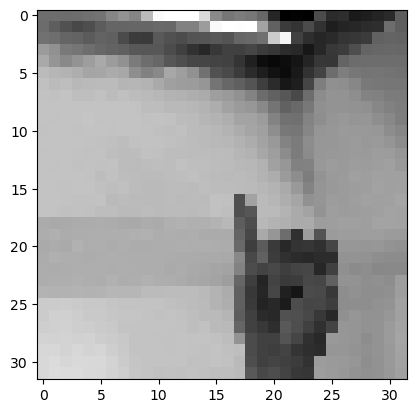

Prediction:  [19]
Label:  19


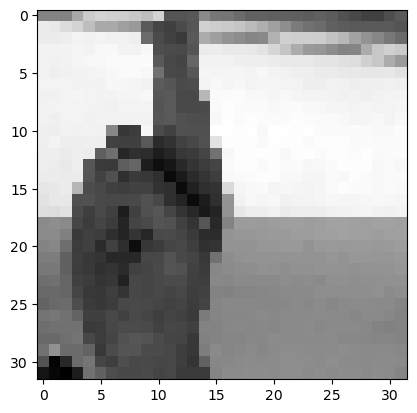

Prediction:  [9]
Label:  9


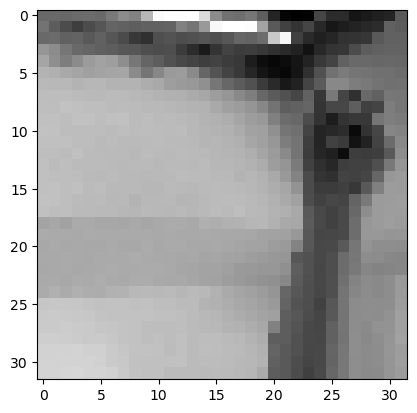

Prediction:  [15]
Label:  18


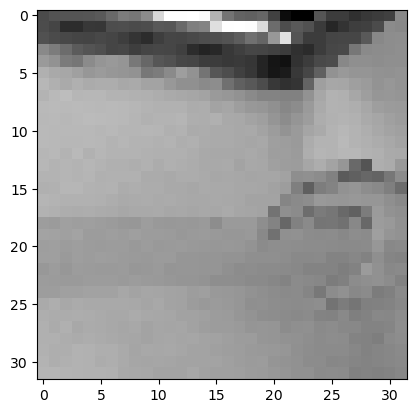

In [205]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [206]:
dev_predictions = make_predictions(X_train, W1, b1, W2, b2)
get_accuracy(dev_predictions, y_train)

0.5648902821316615